# Explore and visualise synthetic data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data

In [2]:
data_path = '/mnt/RAID/projects/PCS956-Project/data/synthetic_vineyard_data.parquet'

# Check if the data exists
try:
    data = pd.read_parquet(data_path)
    print(f"Data loaded from {data_path}")
except FileNotFoundError:
    print(f"File not found: {data_path}. Please generate the data first.")
    raise

# Show first few rows of data
data.head()

Data loaded from /mnt/RAID/projects/PCS956-Project/data/synthetic_vineyard_data.parquet


,DTM,CHM,NDVI,LAI,Botrytis_Risk
0,75.838611,0.993055,0.534434,-0.042316,0.0
1,75.590000,0.000000,0.283146,0.113941,0.0
2,75.548197,0.000000,0.276949,0.159716,0.0
3,76.242520,0.000000,0.325712,-0.157289,0.0
4,76.394267,0.000000,0.325347,0.019782,0.0


# Reshape into 2D grid

In [3]:
field_width = 20  # meters
field_length = 200  # meters
resolution = 0.5  # meters per grid cell

grid_width = int(field_width / resolution)  # Number of grid cells in width
grid_length = int(field_length / resolution)  # Number of grid cells in length

# Reshape each column into a 2D grid
DTM = data['DTM'].values.reshape(grid_length, grid_width)
CHM = data['CHM'].values.reshape(grid_length, grid_width)
NDVI = data['NDVI'].values.reshape(grid_length, grid_width)
LAI = data['LAI'].values.reshape(grid_length, grid_width)
Botrytis_Risk = data['Botrytis_Risk'].values.reshape(grid_length, grid_width)

# Visualise 2D grids

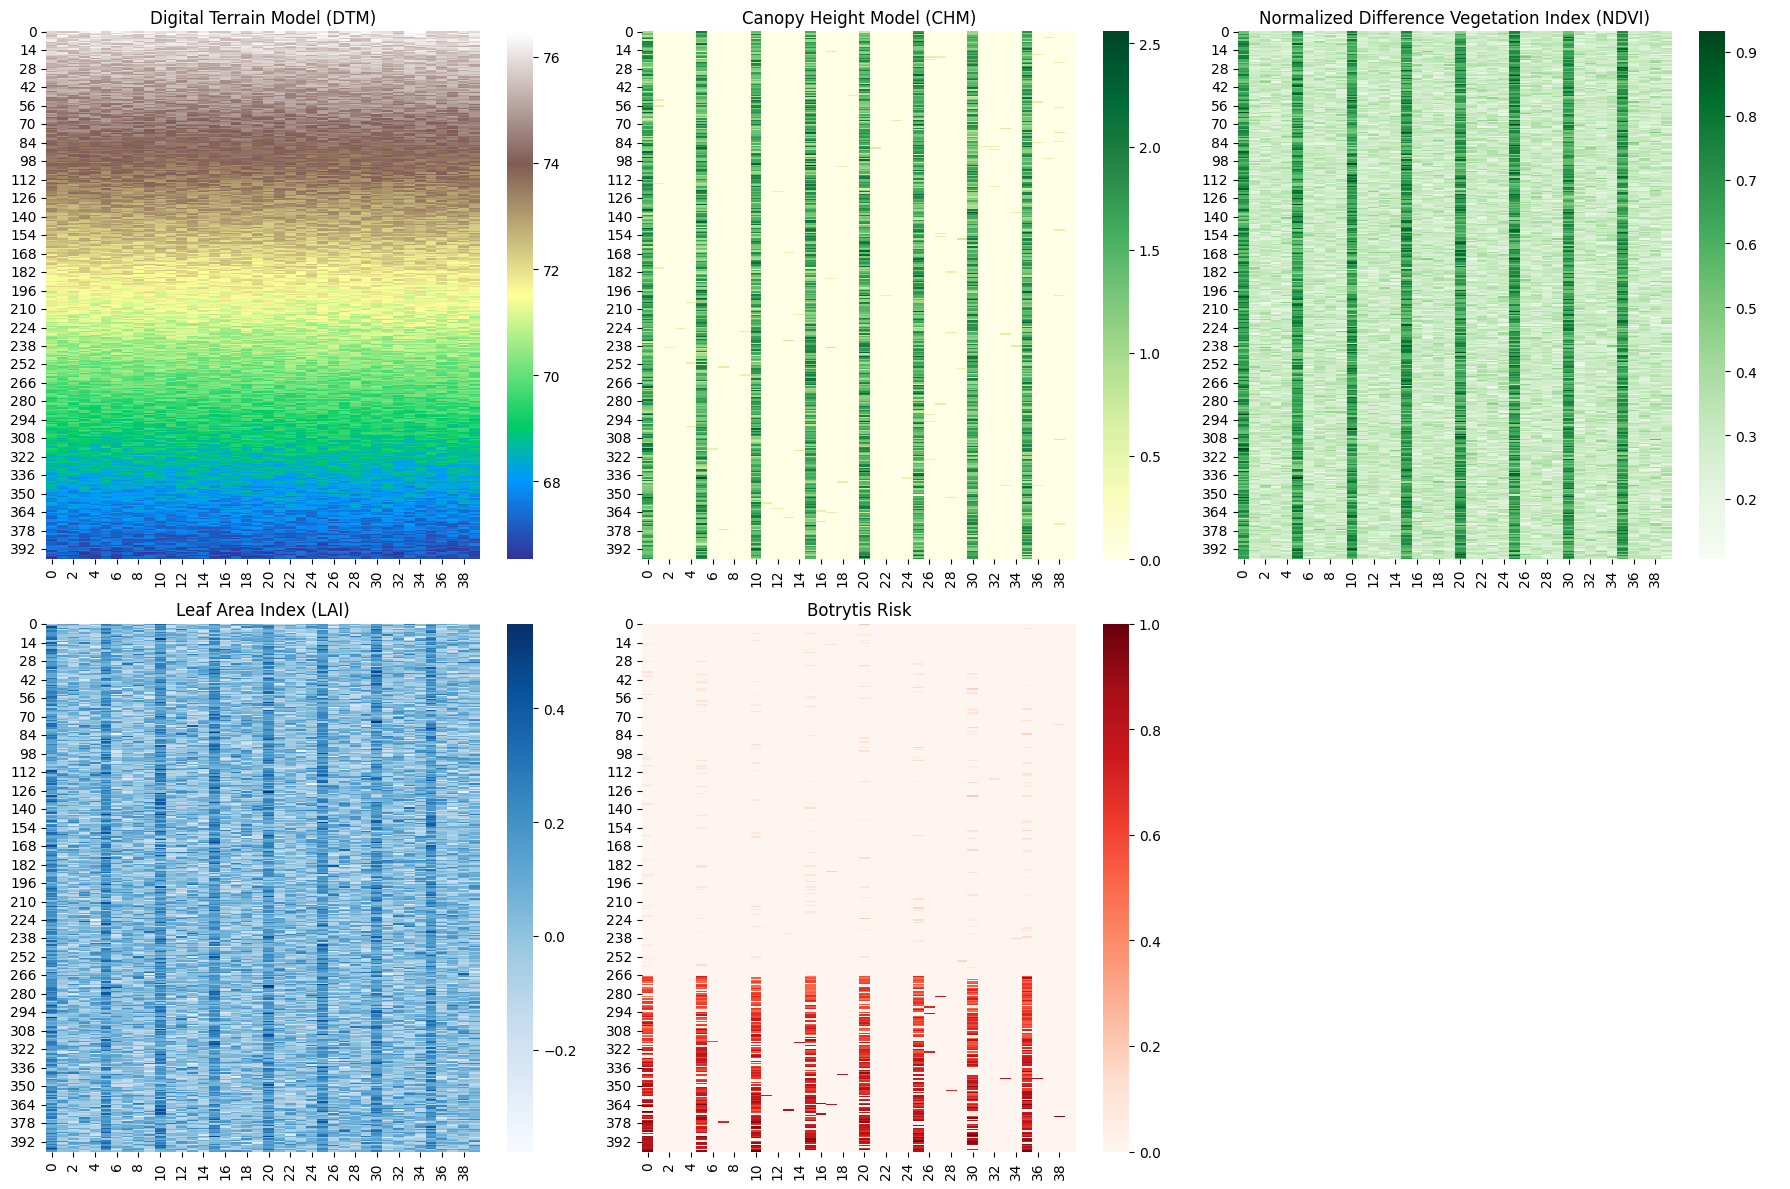

In [4]:
# Set up the figure size for better clarity
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot Digital Terrain Model (DTM)
sns.heatmap(DTM, ax=axes[0, 0], cmap='terrain', annot=False)
axes[0, 0].set_title('Digital Terrain Model (DTM)')

# Plot Canopy Height Model (CHM)
sns.heatmap(CHM, ax=axes[0, 1], cmap='YlGn', annot=False)
axes[0, 1].set_title('Canopy Height Model (CHM)')

# Plot Normalized Difference Vegetation Index (NDVI)
sns.heatmap(NDVI, ax=axes[0, 2], cmap='Greens', annot=False)
axes[0, 2].set_title('Normalized Difference Vegetation Index (NDVI)')

# Plot Leaf Area Index (LAI)
sns.heatmap(LAI, ax=axes[1, 0], cmap='Blues', annot=False)
axes[1, 0].set_title('Leaf Area Index (LAI)')

# Plot Botrytis Risk
sns.heatmap(Botrytis_Risk, ax=axes[1, 1], cmap='Reds', annot=False)
axes[1, 1].set_title('Botrytis Risk')

# Leave the last plot empty for spacing
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Explore Relationships

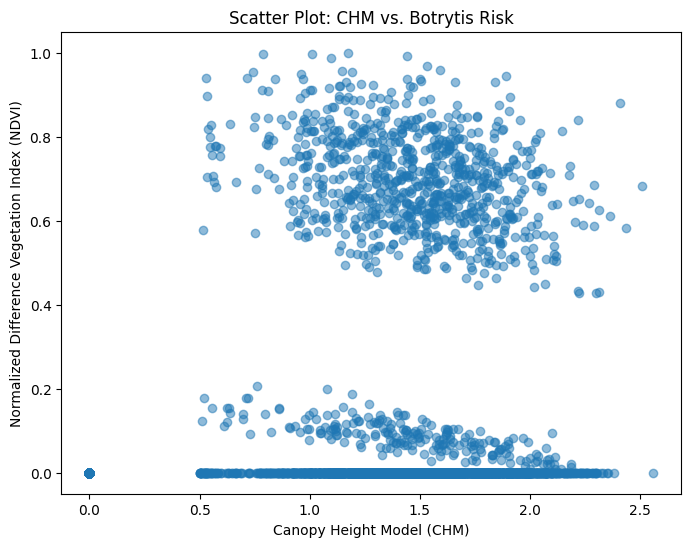

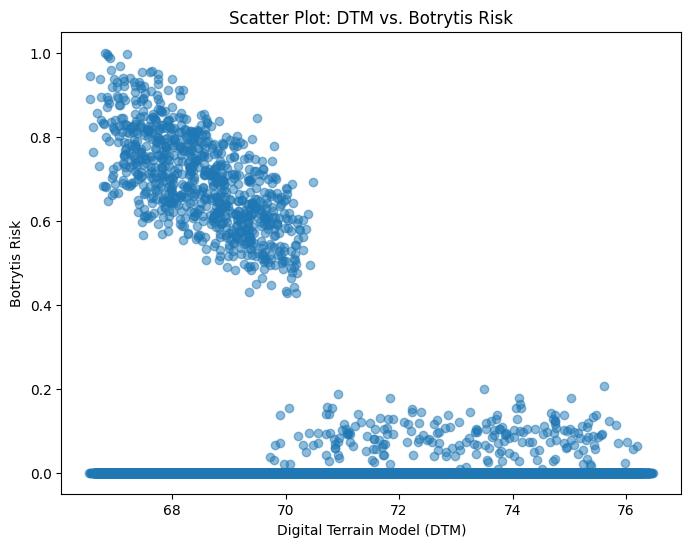

In [5]:
# Calculate and visualize the correlation matrix
corr = data.corr()

# Scatter plot between Canopy Height Model (CHM) and NDVI
plt.figure(figsize=(8, 6))
plt.scatter(data['CHM'], data['Botrytis_Risk'], alpha=0.5)
plt.title('Scatter Plot: CHM vs. Botrytis Risk')
plt.xlabel('Canopy Height Model (CHM)')
plt.ylabel('Normalized Difference Vegetation Index (NDVI)')
plt.show()

# Scatter plot between DTM and Botrytis Risk
plt.figure(figsize=(8, 6))
plt.scatter(data['DTM'], data['Botrytis_Risk'], alpha=0.5)
plt.title('Scatter Plot: DTM vs. Botrytis Risk')
plt.xlabel('Digital Terrain Model (DTM)')
plt.ylabel('Botrytis Risk')
plt.show()
